In [23]:
import jax.numpy as jnp
import jax
from jax import jit
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from scipy.linalg import expm

Model = namedtuple('Model', ['mu', 'lam'])
Params = namedtuple('Params', ['nx', 'nu', 'nz', 'P', 'Q', 'R', 'Qf', 'Xref', 'tf', 'dt', 'N', 'model'])

nx = 2
nu = 1
nz = 3
P = jnp.block([
    jnp.eye(nx), jnp.zeros((nx, nz-nx))
])

Q = 0.5 * jnp.eye(2)
R = 0.05 * jnp.eye(nu)
Qf = 1e2 * Q
Xref = jnp.array([0.0, 0.0])

tf = 5.0
dt = 0.05
N = int(tf / dt) + 1

model = Model(
    mu = -1.0,
    lam = 1.0,
)

params = Params(
    nx = nx,
    nu = nu,
    nz = nz,
    P = P,
    Q = Q,
    R = R,
    Qf = Qf,
    Xref = Xref,
    tf = tf,
    dt = dt,
    N = N,
    model = model,
)

def c2d(A, B, dt):
    n = A.shape[0]
    M = np.block([
        [A, B],
        [np.zeros((B.shape[1], A.shape[0] + B.shape[1]))]
    ])
    M_exp = expm(M * dt)
    A_d = M_exp[:n, :n]
    B_d = M_exp[:n, n:]
    return A_d, B_d

In [24]:
def continuous_dynamics(x, u, params):
    x1, x2 = x[0], x[1]
   
    # xdot = jnp.array([
    #     x2,
    #     params.model.mu * (1 - x1**2) * x2 - x1 + u[0]
    # ])
    # xdot = jnp.array([
    #     jnp.sin(x1) + u[0],
    #     0.0,
    # ])
    xdot = jnp.array([
        params.model.mu * x1,
        params.model.lam * (x2 - x1**2) + u[0]
    ])

    return xdot

def rk4_step(x, u, params, continuous_dynamics):
    k1 = params.dt*continuous_dynamics(x, u, params)
    k2 = params.dt*continuous_dynamics(x + k1/2, u, params)
    k3 = params.dt*continuous_dynamics(x + k2/2, u, params)
    k4 = params.dt*continuous_dynamics(x + k3, u, params)
    
    x_next = x + 1/6 * (k1 + 2*k2 + 2*k3 + k4)
    
    return x_next

# def discrete_dynamics(x, u, params, continuous_dynamics):
#     return rk4_step(x, u, params, continuous_dynamics)


def discrete_dynamics_koopman(z, u, params):
    Ac = jnp.array([
        [model.mu, 0.0, 0.0],
        [0.0, model.lam, -model.lam],
        [0.0, 0.0, 2.0*model.mu]
    ])
    Bc = jnp.array([
        [0.0],
        [1.0],
        [0.0]
    ])
    continuous_dynamics = lambda z, u, params: Ac @ z + Bc @ u
    return rk4_step(z, u, params, continuous_dynamics)

# Dynamics derivatives
@jax.jit
def dfdz(z, u, params):
    return jax.jacobian(lambda z, u : discrete_dynamics_koopman(z, u, params), argnums=0)(z, u)

@jax.jit
def dfdu(z, u, params):
    return jax.jacobian(lambda z, u : discrete_dynamics_koopman(z, u, params), argnums=1)(z, u)

def lift_state(x):
    x1, x2 = x[0], x[1]
    
    return jnp.array([
        x1,
        x2,
        x1 ** 2,
    ])

z = jnp.array([5.0, -2.0, 5.**2])
u = jnp.array([1.])

display(dfdz(z, u, params))
display(dfdu(z, u, params))
# display(params.P)

Array([[ 0.9512294 ,  0.        ,  0.        ],
       [ 0.        ,  1.0512711 , -0.0488112 ],
       [ 0.        ,  0.        ,  0.90483755]], dtype=float32)

Array([[0.       ],
       [0.0512711],
       [0.       ]], dtype=float32)

In [25]:
def term_cost(x, params):
    xerr = x - params.Xref
    return 1/2 * jnp.dot(xerr, params.Qf @ xerr)

# Terminal cost derivatives
@jax.jit
def terminal_cost_expansion(z, params):
    J_z = jax.grad(lambda x: term_cost(params.P @ z, params), argnums=0)(z)
    J_zz = jax.hessian(lambda z: term_cost(params.P @ z, params), argnums=0)(z)

    return J_z, J_zz

In [26]:
# z = np.array([1, 2, 3.0])
# J_z, J_zz = terminal_cost_expansion(z, params)
# display(J_z, J_z.shape)
# display(J_zz, J_zz.shape)

In [27]:
def stage_cost(x, u, params):
    xerr = x - params.Xref
    c1 = 1/2 * jnp.dot(xerr, params.Q @ xerr)
    c2 = 1/2 * jnp.dot(u, params.R @ u)
    return c1 + c2

@jax.jit
def stage_cost_expansion(z, u, params):
    J_z = jax.grad(lambda z, u: stage_cost(params.P @ z, u, params), argnums=0)(z, u)
    J_u = jax.grad(lambda z, u: stage_cost(params.P @ z, u, params), argnums=1)(z, u)
    J_zz = jax.hessian(lambda z, u: stage_cost(params.P @ z, u, params), argnums=0)(z, u)
    J_uu = jax.hessian(lambda z, u: stage_cost(params.P @ z, u, params), argnums=1)(z, u)
    J_zu = jax.jacobian(jax.grad(lambda z, u: stage_cost(params.P @ z, u, params), argnums=0), argnums=1)(z, u)
    J_uz = J_zu.T
    
    return J_z, J_u, J_zz, J_uu, J_zu, J_uz

In [28]:
z = np.array([1.2235, 5.32, 3.0])
u = np.array([10.5])
J_z, J_u, J_zz, J_uu, J_zu, J_uz = stage_cost_expansion(z, u, params)

display(J_z)
display(J_u)
display(J_zz)
display(J_uu)
display(J_zu)
display(J_uz)

Array([0.61175, 2.66   , 0.     ], dtype=float32)

Array([0.52500004], dtype=float32)

Array([[0.5, 0. , 0. ],
       [0. , 0.5, 0. ],
       [0. , 0. , 0. ]], dtype=float32)

Array([[0.05]], dtype=float32)

Array([[0.],
       [0.],
       [0.]], dtype=float32)

Array([[0., 0., 0.]], dtype=float32)

In [29]:
def trajectory_cost(xbar, ubar, params):
    J = 0.0
    for i in range(N-1):
        Xi = xbar[i]
        Ui = ubar[i]
        J += stage_cost(Xi, Ui, params)
    
    J += term_cost(xbar[-1], params)
    return J

def backwards(zbar, ubar, regu, params):
    Zn = zbar[-1]
    V_z, V_zz = terminal_cost_expansion(Zn, params)
    
    ks = np.zeros((params.N, params.nu))
    Ks = np.zeros((params.N, params.nu, params.nz))
    
    delta_J = 0.0
    
    for i in range(params.N - 2, -1, -1):
        Zi = zbar[i]
        Ui = ubar[i]

        f_z, f_u = dfdz(Zi, Ui, params), dfdu(Zi, Ui, params)
        l_z, l_u, l_zz, l_uu, l_zu, l_uz = stage_cost_expansion(Zi, Ui, params)

        # Q_terms
        Q_z  = l_z  + f_z.T@V_z
        Q_u  = l_u  + f_u.T@V_z
        Q_zz = l_zz + f_z.T@V_zz@f_z
        Q_uz = l_uz + f_u.T@V_zz@f_z
        Q_uu = l_uu + f_u.T@V_zz@f_u

        # gains
        Q_uu_regu = Q_uu + regu * jnp.eye(nu)
        Q_uu_inv = np.linalg.inv(Q_uu_regu)

        k = -Q_uu_inv@Q_u
        K = -Q_uu_inv@Q_uz
                
        V_z  = Q_z + K.T@Q_u + Q_uz.T@k + K.T@Q_uu@k
        V_zz = Q_zz + 2*K.T@Q_uz + K.T@Q_uu@K
        
        ks[i] = k
        Ks[i] = K
        delta_J += Q_u.T@k + 0.5*k.T@Q_uu@k
    
    print(f"{delta_J=}")
    return ks, Ks, delta_J

def forwards(xbar, zbar, ubar, ds, Ks, alpha, params):
    xbar_new = np.zeros((params.N, params.nx))
    zbar_new = np.zeros((params.N, params.nz))
    ubar_new = np.zeros((params.N-1, params.nu))
    
    xbar_new[0] = xbar[0]
    zbar_new[0] = lift_state(xbar_new[0])
        
    for k in range(params.N-1):
        ubar_new[k] = ubar[k] + alpha * ds[k] + Ks[k] @ (zbar_new[k] - zbar[k])
        
        xbar_new[k+1] = rk4_step(xbar_new[k], ubar_new[k], params, continuous_dynamics)
        zbar_new[k+1] = lift_state(xbar_new[k+1])
    
    J = trajectory_cost(xbar_new, ubar_new, params)

    return xbar_new, zbar_new, ubar_new, J

def simulate(x0, ubar, params):
    xbar = np.zeros((params.N, params.nx))
    zbar = np.zeros((params.N, params.nz))
    
    xbar[0] = x0
    zbar[0] = lift_state(xbar[0])
    
    for i in range(params.N-1):
        xbar[i+1] = rk4_step(xbar[i], ubar[i], params, continuous_dynamics)
        zbar[i+1] = lift_state(xbar[i+1])
    
    return xbar, zbar, ubar

def iLQR(x0, uguess, params, atol=1e-3, max_iters=100, max_ls_iters=20):
    xbar, zbar, ubar = simulate(x0, uguess, params)
    
    for ilqr_iter in range(max_iters):
        Jold = trajectory_cost(xbar, ubar, params)
        alpha = 1.0
        
        ks, Ks, delta_J = backwards(zbar, ubar, 1e-3, params)
        xbar_new, zbar_new, ubar_new, J = forwards(xbar, zbar, ubar, ks, Ks, alpha, params)
        
        if np.abs(delta_J) < atol:
            print(f"Converged at iteration {ilqr_iter}")
            print(f"{J=}, {params.Xref=}, {xbar_new[-1]=}")
            return xbar_new, zbar_new, ubar_new, J
        
        for _ in range(max_ls_iters):
            if J < Jold:
                xbar = xbar_new
                zbar = zbar_new
                ubar = ubar_new
                
                print(f"Line search succeeded at iteration {ilqr_iter=}, {alpha=}, {Jold=}, {J=}")
                break
            
            alpha *= 0.5
            xbar_new, zbar_new, ubar_new, J = forwards(xbar, zbar, ubar, ks, Ks, alpha, params)
        else:
            raise RuntimeError(f"Line search failed at iteration {ilqr_iter}")
        

In [30]:
model = Model(
    mu = -1.0,
    lam = 1.0,
)

nx = 2
nu = 1
nz = 3
P = jnp.block([
    jnp.eye(nx), jnp.zeros((nx, nz-nx))
])

Q = 0.5 * jnp.eye(nx)
R = 0.1 * jnp.eye(nu)
Qf = 1e2 * Q
Xref = jnp.array([0.0, 0.0])

tf = 8.0
dt = 0.05
N = int(tf / dt) + 1

params = Params(
    nx = nx,
    nu = nu,
    nz = nz,
    P = P,
    Q = Q,
    R = R,
    Qf = Qf,
    Xref = Xref,
    tf = tf,
    dt = dt,
    N = N,
    model = model,
)

ts = np.arange(0, params.tf + params.dt, params.dt)
uguess = np.ones((params.N-1, params.nu))

xs, us, Ks = iLQR(
    x0=jnp.array([5.0, -2.0]),
    uguess=uguess,
    params=params,
    atol=1e-3,
    max_iters=100,
    max_ls_iters=20,
)

delta_J=Array(-8.636761e+08, dtype=float32)
Line search succeeded at iteration ilqr_iter=0, alpha=1.0, Jold=Array(2.1193693e+10, dtype=float32), J=Array(1.8344518e+10, dtype=float32)
delta_J=Array(-46719628., dtype=float32)
Line search succeeded at iteration ilqr_iter=1, alpha=1.0, Jold=Array(1.8344518e+10, dtype=float32), J=Array(1.6541446e+10, dtype=float32)
delta_J=Array(-42122652., dtype=float32)
Line search succeeded at iteration ilqr_iter=2, alpha=1.0, Jold=Array(1.6541446e+10, dtype=float32), J=Array(1.4915499e+10, dtype=float32)
delta_J=Array(-37982176., dtype=float32)
Line search succeeded at iteration ilqr_iter=3, alpha=1.0, Jold=Array(1.4915499e+10, dtype=float32), J=Array(1.3449375e+10, dtype=float32)
delta_J=Array(-34248708., dtype=float32)
Line search succeeded at iteration ilqr_iter=4, alpha=1.0, Jold=Array(1.3449375e+10, dtype=float32), J=Array(1.2127364e+10, dtype=float32)
delta_J=Array(-30882230., dtype=float32)
Line search succeeded at iteration ilqr_iter=5, alpha=1.

KeyboardInterrupt: 

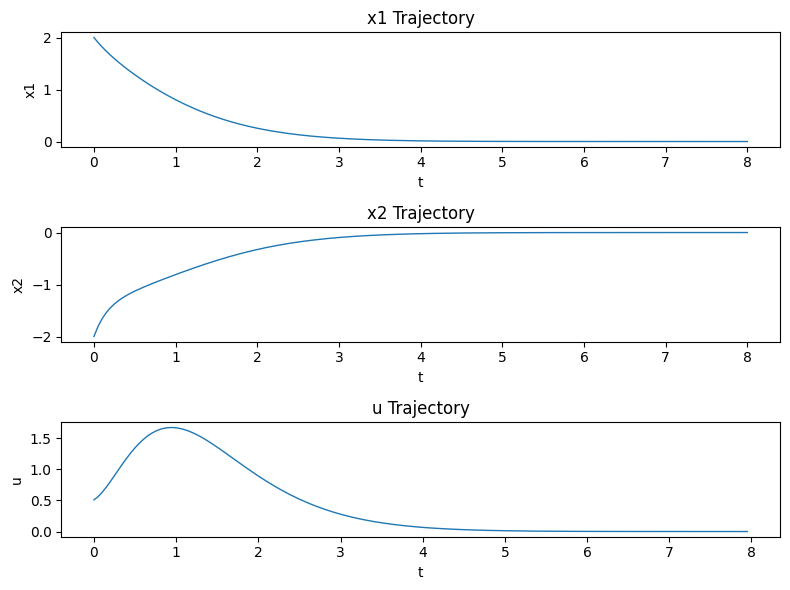

In [ ]:
# Plot the trajectory
fig, ax = plt.subplots(3,1, figsize=(8, 6))

ax[0].plot(ts, xs[:, 0], label="x1", linewidth=1)
ax[1].plot(ts, xs[:, 1], label="x2", linewidth=1)
ax[2].plot(ts[:-1], us[:, 0], label="u", linewidth=1)

ax[0].set_title("x1 Trajectory")
ax[0].set_xlabel("t")
ax[0].set_ylabel("x1")

ax[1].set_title("x2 Trajectory")
ax[1].set_xlabel("t")
ax[1].set_ylabel("x2")

ax[2].set_title("u Trajectory")
ax[2].set_xlabel("t")
ax[2].set_ylabel("u")

plt.tight_layout()
plt.show()